In [1]:
#@title Imports. { vertical-output: true }

import os

from matplotlib import pyplot as plt
import numpy as np

from perch_hoplite.agile import audio_loader
from perch_hoplite.agile import classifier
from perch_hoplite.agile import classifier_data
from perch_hoplite.agile import embedding_display
from perch_hoplite.agile import source_info
from perch_hoplite.db  import brutalism
from perch_hoplite.db import score_functions
from perch_hoplite.db  import search_results
from perch_hoplite.db import sqlite_usearch_impl
from perch_hoplite.zoo import model_configs


In [2]:
#@title Load model and connect to database. { vertical-output: true }

#@markdown Location of database containing audio embeddings.
db_path = '/workspace/mojave_data'  #@param {type:'string'}
#@markdown Identifier (eg, name) to attach to labels produced during validation.
annotator_id = 'linnaeus'  #@param {type:'string'}

db = sqlite_usearch_impl.SQLiteUsearchDB.create(db_path)
db_model_config = db.get_metadata('model_config')
embed_config = db.get_metadata('audio_sources')
model_class = model_configs.get_model_class(db_model_config.model_key)
embedding_model = model_class.from_config(db_model_config.model_config)
audio_sources = source_info.AudioSources.from_config_dict(embed_config)
if hasattr(embedding_model, 'window_size_s'):
  window_size_s = embedding_model.window_size_s
else:
  window_size_s = 5.0
audio_filepath_loader = audio_loader.make_filepath_loader(
    audio_sources=audio_sources,
    window_size_s=window_size_s,
    sample_rate_hz=embedding_model.sample_rate,
)

/workspace/.venv/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


# Search

In [3]:
#@title Load query audio. { vertical-output: true }

#@markdown The `query_uri` can be a URL, filepath, or Xeno-Canto ID
#@markdown (like `xc777802`, containing an Eastern Whipbird (`easwhi1`)).
query_uri = 'xc875450' #cactus wren #@param {type:'string'}
query_label = 'CACW'  #@param {type:'string'}

query = embedding_display.QueryDisplay(
    uri=query_uri, offset_s=0.0, window_size_s=5.0, sample_rate_hz=48000)
_ = query.display_interactive()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='offset_s', max=137.51475), …

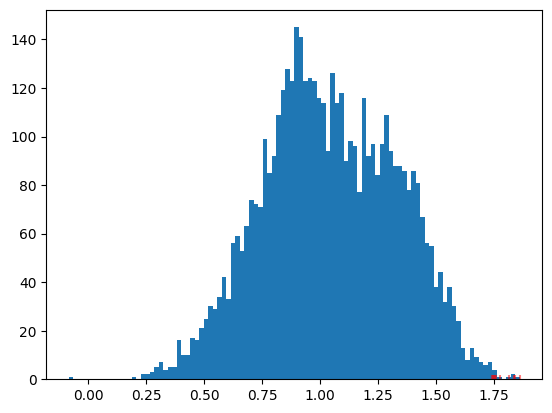

In [10]:
#@title Embed the Query and Search. { vertical-output: true }

#@markdown Number of results to find and display.
num_results = 10  #@param
query_embedding = embedding_model.embed(
    query.get_audio_window()).embeddings[0, 0]

#@markdown If checked, search for examples
#@markdown near a particular target score.
target_sampling = False  #@param {type: 'boolean'}

#@markdown When target sampling, target this score.
target_score = -1.0  #@param
if not target_sampling:
  target_score = None

#@markdown If True, search the full DB. Otherwise, use approximate
#@markdown nearest-neighbor search.
exact_search = True  #@param {type: 'boolean'}

if exact_search:
  score_fn = score_functions.get_score_fn('dot', target_score=target_score)
  results, all_scores = brutalism.threaded_brute_search(
      db, query_embedding, num_results, score_fn=score_fn)
  # TODO(tomdenton): Better histogram when target sampling.
  _ = plt.hist(all_scores, bins=100)
  hit_scores = [r.sort_score for r in results.search_results]
  plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
              color='r', alpha=0.5)
else:
  ann_matches = db.ui.search(query_embedding, count=num_results)
  results = search_results.TopKSearchResults(top_k=num_results)
  for k, d in zip(ann_matches.keys, ann_matches.distances):
    results.update(search_results.SearchResult(k, d))


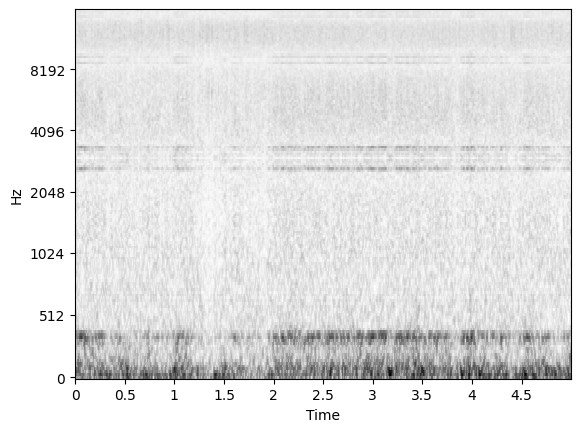

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

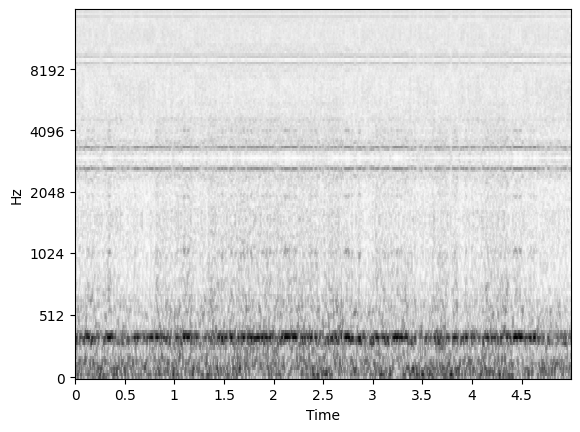

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

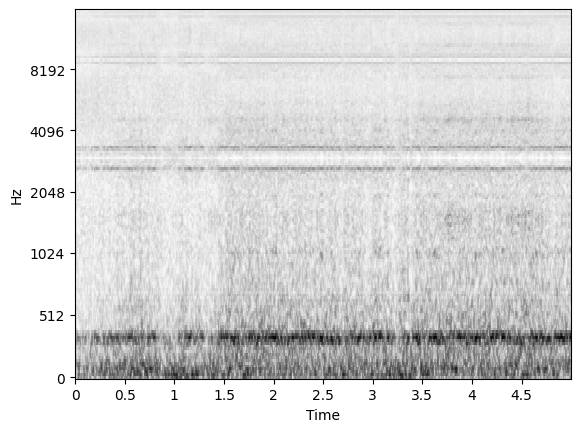

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

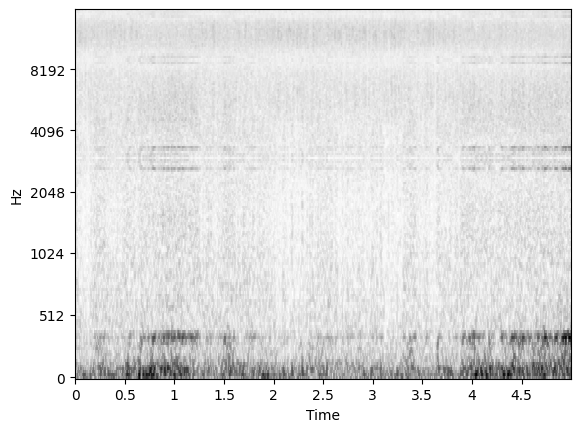

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

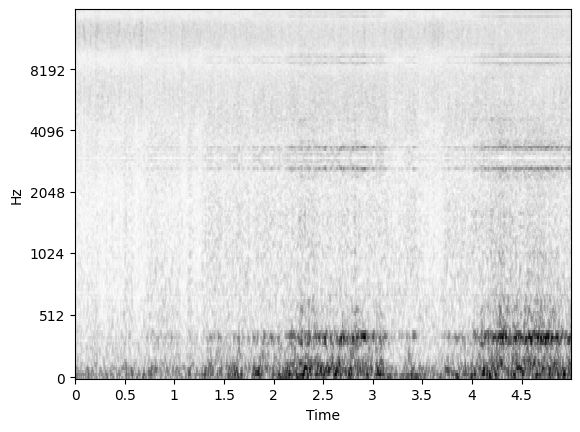

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

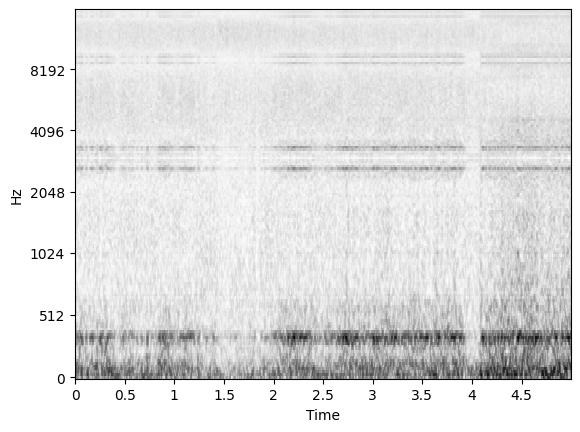

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

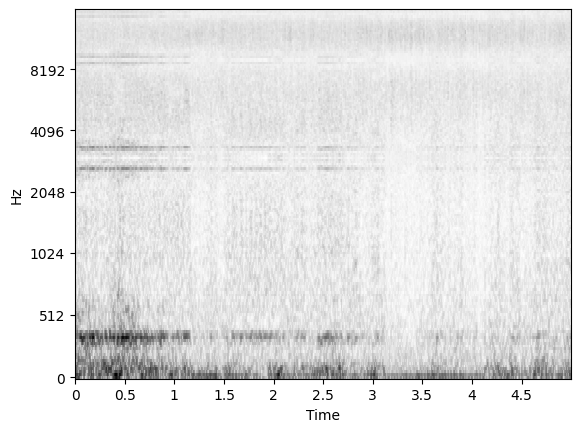

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

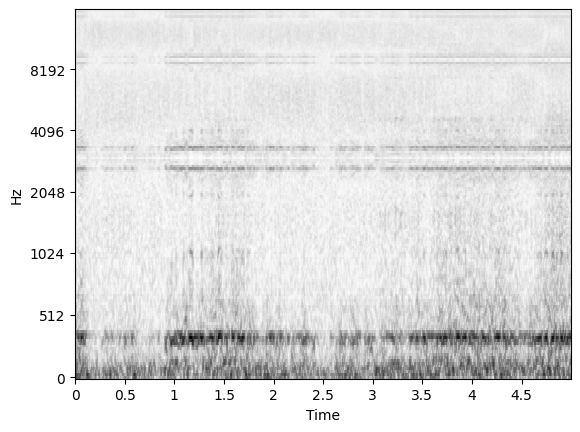

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

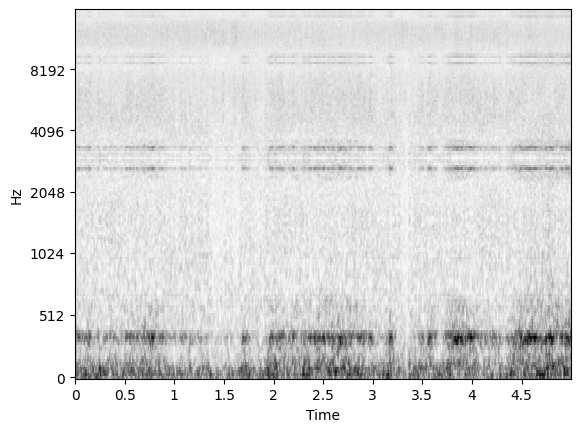

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

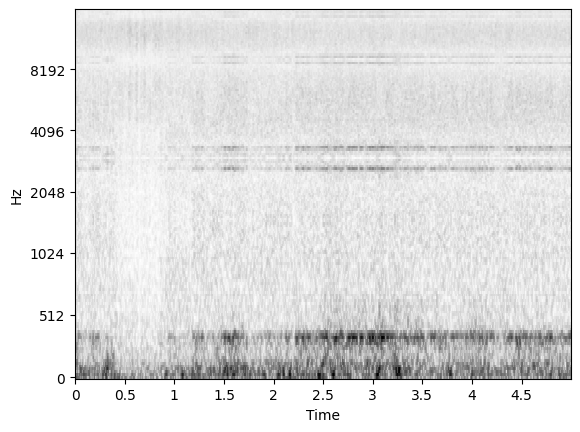

GridspecLayout(children=(Button(button_style='warning', description='CACW', layout=Layout(grid_area='widget001…

Button(description='Prev Page', style=ButtonStyle())

Button(description='Next Page', style=ButtonStyle())

In [11]:
#@title Display Results. { vertical-output: true }

display_results = embedding_display.EmbeddingDisplayGroup.from_search_results(
    results, db, sample_rate_hz=32000, frame_rate=100,
    audio_loader=audio_filepath_loader)
display_results.display(positive_labels=[query_label])

In [12]:
#@title Save data labels. { vertical-output: true }

prev_lbls, new_lbls = 0, 0
for lbl in display_results.harvest_labels(annotator_id):
  check = db.insert_label(lbl, skip_duplicates=True)
  new_lbls += check
  prev_lbls += (1 - check)
print('\nnew_lbls: ', new_lbls)
print('\nprev_lbls: ', prev_lbls)


new_lbls:  0

prev_lbls:  10


# Classify

In [13]:
#@title Classifier training. { vertical-output: true }

#@markdown Set of labels to classify. If None, auto-populated from the DB.
target_labels = None  #@param

#@markdown Classifier traning hyperparams. These should not require tuning.
learning_rate = 1e-3  #@param
weak_neg_weight = 0.05  #@param
l2_mu = 0.000  #@param
num_steps = 128  #@param

train_ratio = 0.9  #@param
batch_size = 128  #@param
weak_negatives_batch_size = 128  #@param
loss_fn_name = 'bce'  #@param ['hinge', 'bce']

data_manager = classifier_data.AgileDataManager(
    target_labels=target_labels,
    db=db,
    train_ratio=train_ratio,
    min_eval_examples=1,
    batch_size=batch_size,
    weak_negatives_batch_size=weak_negatives_batch_size,
    rng=np.random.default_rng(seed=5))
print('Training for target labels : ')
print(data_manager.get_target_labels())
linear_classifier, eval_scores = classifier.train_linear_classifier(
    data_manager=data_manager,
    learning_rate=learning_rate,
    weak_neg_weight=weak_neg_weight,
    num_train_steps=num_steps,
)
print('\n' + '-' * 80)
top1 = eval_scores['top1_acc']
print(f'top-1      {top1:.3f}')
rocauc = eval_scores['roc_auc']
print(f'roc_auc    {rocauc:.3f}')
cmap = eval_scores['cmap']
print(f'cmap       {cmap:.3f}')

# Save linear classifier.
linear_classifier.save(os.path.join(db_path, 'agile_classifier_v2.pt'))

Training for target labels : 
('CACW',)


Loss 0.02471143:  78%|███████▊  | 100/128 [00:01<00:00, 71.20it/s] 


--------------------------------------------------------------------------------
top-1      0.500
roc_auc    nan
cmap       nan



/workspace/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/workspace/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [14]:
#@title Review Classifier Results. { vertical-output: true }

#@markdown Number of results to find and display.
target_label = 'easwhi1'  #@param {type:'string'}
num_results = 50  #@param

target_label_idx = data_manager.get_target_labels().index(target_label)
class_query = linear_classifier.beta[:, target_label_idx]
bias = linear_classifier.beta_bias[target_label_idx]

#@markdown Number of (randomly selected) database entries to search over.
sample_size = 1_000_000  #@param

#@markdown Whether to use margin-sampling. If checked, search for examples
#@markdown with logits near a particular target score (usually 0).
margin_sampling = False  #@param {type: 'boolean'}

#@markdown When margin sampling, target this logit.
margin_target_score = -0.0  #@param
if not margin_sampling:
  margin_target_score = None
score_fn = score_functions.get_score_fn(
    'dot', bias=bias, target_score=margin_target_score)
results, all_scores = brutalism.threaded_brute_search(
    db, class_query, num_results, score_fn=score_fn,
    sample_size=sample_size)

# TODO(tomdenton): Better histogram when margin sampling.
_ = plt.hist(all_scores, bins=100)
hit_scores = [r.sort_score for r in results.search_results]
plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
            color='r', alpha=0.5)


ValueError: tuple.index(x): x not in tuple

In [ ]:
#@title Display Results. { vertical-output: true }

display_results = embedding_display.EmbeddingDisplayGroup.from_search_results(
    results, db, sample_rate_hz=32000, frame_rate=100,
    audio_loader=audio_filepath_loader)
display_results.display(positive_labels=[target_label])

In [ ]:
#@title Save data labels. { vertical-output: true }

prev_lbls, new_lbls = 0, 0
for lbl in display_results.harvest_labels(annotator_id):
  check = db.insert_label(lbl, skip_duplicates=True)
  new_lbls += check
  prev_lbls += (1 - check)
print('\nnew_lbls: ', new_lbls)
print('\nprev_lbls: ', prev_lbls)

In [ ]:
#@title Run inference with trained classifier. { vertical-output: true }

output_csv_filepath = ''  #@param {type:'string'}
logit_threshold = 1.0  #@param
# Set labels to a tuple of desired labels if you want to run inference on a
# subset of the labels.
labels = None  #@param

classifier.write_inference_csv(
    linear_classifier, db, output_csv_filepath, logit_threshold, labels=labels)
